
------

### ---- EXPLORACIÓN 20 RATAS SANAS : COMPARACION DE DISTINTOS THRESHOLDS ---- Caso th = 0.2
#### DATOS ALEJANDRO RATAS (1-20) 16.10.25

------

In [1]:

"""
Pipeline iterativo para comparar thresholds sin saturar memoria.
Ejecutar threshold por threshold, guardando solo métricas agregadas.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

In [2]:
# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (78).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fall

In [3]:
COL_TAU, COL_D, COL_V = 0, 1, 2

# ===== FUNCIONES HELPER =====
def clean_threshold_data(all_rats, min_n_fibers=100):
    """Limpieza estándar"""
    cleaned = {}
    for rat_id, data in all_rats.items():
        cleaned[rat_id] = {}
        for (i,j), arr in data.items():
            arr = np.asarray(arr)
            if arr.ndim != 2 or arr.shape[1] < 3 or len(arr) < min_n_fibers:
                continue
            
            finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
            positive = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            valid = finite & positive
            
            arr_clean = arr[valid]
            if len(arr_clean) >= min_n_fibers:
                cleaned[rat_id][(int(i), int(j))] = arr_clean.astype(np.float32)
    
    return cleaned

def extract_connection_metrics(cleaned_rats, min_rats=9):
    """Extrae solo métricas agregadas (ligero)"""
    from collections import defaultdict
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med': [], 'tau_range': [], 'tau_p95': [],
        'n_fibers': [], 'D_med': [], 'D_max': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range'].append(np.ptp(tau_ms))
            conn_data[(i,j)]['tau_p95'].append(np.percentile(tau_ms, 95))
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med'].append(np.median(D_mm))
            conn_data[(i,j)]['D_max'].append(np.max(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'roi_i_name': roi_label(i, name_map), 'roi_j_name': roi_label(j, name_map),
            'n_rats': n_rats,
            'tau_mean': np.mean(stats['tau_med']),
            'tau_range_mean': np.mean(stats['tau_range']),
            'tau_p95_mean': np.mean(stats['tau_p95']),
            'D_mean': np.mean(stats['D_med']),
            'D_max_mean': np.mean(stats['D_max']),
            'n_fibers_mean': np.mean(stats['n_fibers']),
        })
    
    return pd.DataFrame(rows)

# ===== PROCESAMIENTO POR THRESHOLD =====
def process_single_threshold(threshold, data_dir='./data/raw/', 
                             min_n_fibers=100, min_rats=9):
    """
    Procesa un threshold completo y devuelve solo métricas agregadas.
    Libera memoria al terminar.
    """
    print(f"\n{'='*60}")
    print(f"Procesando threshold {threshold}")
    print(f"{'='*60}")
    
    # 1. Cargar
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}'
    
    if not path.exists():
        print(f"❌ Path no encontrado: {path}")
        return None
    
    for f in path.glob(f'th-{threshold}_R*_b20_r_Fit_Histogram_Tau_all_fibers.dat'):
        rat_id = f.stem.split('_')[1]
        with open(f, 'rb') as fh:
            rats[rat_id] = pickle.load(fh)
    
    print(f"  Ratas cargadas: {len(rats)}")
    n_conn_raw = sum(len(d) for d in rats.values())
    print(f"  Conexiones raw: {n_conn_raw}")
    
    # 2. Limpiar
    cleaned = clean_threshold_data(rats, min_n_fibers=min_n_fibers)
    n_conn_clean = sum(len(d) for d in cleaned.values())
    print(f"  Conexiones limpias: {n_conn_clean} ({100*n_conn_clean/n_conn_raw:.1f}%)")
    
    # 3. Agregar
    df_metrics = extract_connection_metrics(cleaned, min_rats=min_rats)
    print(f"  Conexiones robustas (≥{min_rats} ratas): {len(df_metrics)}")
    
    # 4. Estadísticas de largo alcance
    top20 = df_metrics.nlargest(20, 'tau_range_mean')
    print(f"\n  📊 Top 20 long-range:")
    print(f"     τ_range: {top20['tau_range_mean'].max():.2f} ms (max)")
    print(f"     τ_range: {top20['tau_range_mean'].mean():.2f} ms (promedio)")
    print(f"     D: {top20['D_mean'].median():.1f} mm (mediana)")
    
    # Liberar memoria
    del rats, cleaned
    
    return df_metrics

In [4]:
import os

path = '../../data/raw/rat_delays_fibers_0.0/th-0.0/'

names = [f for f in os.listdir(path) if 'name' in f]

# Abrir archivo .txt con nombres de ROIs y .dat con datos en formato diccionario
with open(path+names[0], 'r') as f:
    roi_names = [line.strip() for line in f.readlines()][1:]
    
print(roi_names), len(roi_names)

['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus', 'Inferior colliculus', 'Secondary auditory area', 'Piriform cortex', 'Substantia nigra', 'Zona incerta', 'Agranular insular cortex', 'Primary somatosensory area', 'Parietal association cortex', 'Secondary visual area', 'EPI', 'LAT', 'MED', 'GENd', 'VENT', 'SPF', 'ATN', 'MTN', 'ILM', 'RT', 'GENv', 'Peri-Subiculum', 'Nucleus accumbens', 'Globus pallidus external', 'Hippocampus', 'Subiculum', 'Subthalamic nucleus', 'Cingulate area 2', 'Entopeduncular nucleus', 'Septal region', 'Brainstem, unspecified', 'Hypothalamic region, unspecified', 'Periaqueductal gray', 'Pontine nuclei', 'Interpeduncular nucleus', 'Frontal association cortex', 'Nucleus of the stria medullaris', 'Basal forebrain region, unspecified', 'Bed nucleus of the stria terminalis', 'Pretectal region', 'Postrhinal cortex', 'Perirhinal area 35', 'Perirhinal area 36', 'Medial entorhinal cortex', 'Lateral entorhinal cortex', 'Primary audi

(None, 78)

In [5]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

roi_label(1, name_map)

'L-Ventricles'

In [ ]:
data_dir = '../../data/raw/'
thresholds = ['0.0', '0.2', '0.4', '0.6', '0.8']

results = {}
summary = []

for th in thresholds:
    df = process_single_threshold(th, data_dir=data_dir, 
                                    min_n_fibers=25, min_rats=4)
    
    if df is not None:
        # Guardar métricas
        results[th] = df
        # df.to_csv(f'../../results/data_analysis/results_th_{th}.csv', index=False)
        print(f"  ✓ Guardado: results_th_{th}.csv")
        
        # Resumen para comparación
        summary.append({
            'threshold': th,
            'n_connections': len(df),
            'top20_tau_range': df.nlargest(20, 'tau_range_mean')['tau_range_mean'].mean(),
            'top20_D': df.nlargest(20, 'tau_range_mean')['D_mean'].median(),
            'median_n_fibers': df['n_fibers_mean'].median(),
        })

# ===== COMPARACIÓN FINAL =====
print("\n" + "="*80)
print("RESUMEN COMPARATIVO")
print("="*80)

df_summary = pd.DataFrame(summary)
print(df_summary.to_string(index=False))
# df_summary.to_csv('../../results/data_analysis/threshold_summary.csv', index=False)


Procesando threshold 0.0
  Ratas cargadas: 18
  Conexiones raw: 64915
  Conexiones limpias: 38254 (58.9%)
  Conexiones robustas (≥4 ratas): 2919

  📊 Top 20 long-range:
     τ_range: 5.04 ms (max)
     τ_range: 4.62 ms (promedio)
     D: 7.1 mm (mediana)
  ✓ Guardado: results_th_0.0.csv

Procesando threshold 0.2
  Ratas cargadas: 18
  Conexiones raw: 64915
  Conexiones limpias: 33810 (52.1%)
  Conexiones robustas (≥4 ratas): 2645

  📊 Top 20 long-range:
     τ_range: 4.29 ms (max)
     τ_range: 3.46 ms (promedio)
     D: 6.4 mm (mediana)
  ✓ Guardado: results_th_0.2.csv

Procesando threshold 0.4
  Ratas cargadas: 18
  Conexiones raw: 64915
  Conexiones limpias: 24644 (38.0%)
  Conexiones robustas (≥4 ratas): 2014

  📊 Top 20 long-range:
     τ_range: 2.84 ms (max)
     τ_range: 2.53 ms (promedio)
     D: 5.8 mm (mediana)
  ✓ Guardado: results_th_0.4.csv

Procesando threshold 0.6
  Ratas cargadas: 18
  Conexiones raw: 64915
  Conexiones limpias: 14180 (21.8%)
  Conexiones robustas (≥4 


ANÁLISIS DE PÉRDIDA

Threshold 0.2 vs 0.0:
  Retiene: 90.6%
  Pierde: 274 conexiones
  Perdidas - τ_range: 1.65 ms
  Perdidas - D: 5.4 mm

Threshold 0.4 vs 0.0:
  Retiene: 69.0%
  Pierde: 905 conexiones
  Perdidas - τ_range: 1.69 ms
  Perdidas - D: 5.6 mm

Threshold 0.6 vs 0.0:
  Retiene: 40.7%
  Pierde: 1732 conexiones
  Perdidas - τ_range: 1.68 ms
  Perdidas - D: 5.6 mm

Threshold 0.8 vs 0.0:
  Retiene: 20.3%
  Pierde: 2325 conexiones
  Perdidas - τ_range: 1.67 ms
  Perdidas - D: 5.4 mm

✅ Figura guardada: threshold_comparison.png


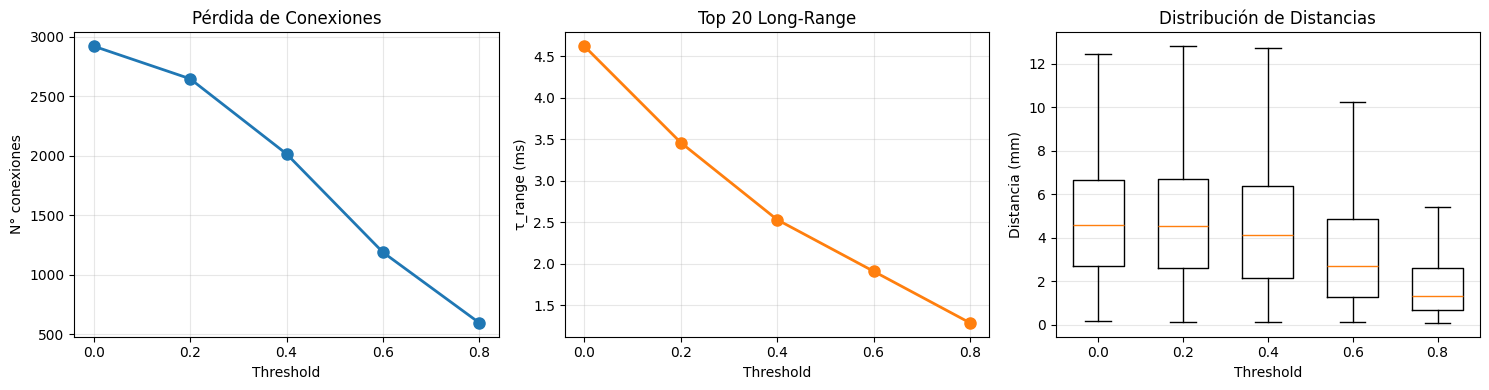

In [ ]:
# ===== ANÁLISIS DE PÉRDIDA =====
if len(results) > 1:
    print("\n" + "="*80)
    print("ANÁLISIS DE PÉRDIDA")
    print("="*80)
    
    baseline_th = min(results.keys())
    baseline_pairs = set(zip(results[baseline_th]['roi_i'], 
                            results[baseline_th]['roi_j']))
    
    for th in sorted(results.keys())[1:]:
        current_pairs = set(zip(results[th]['roi_i'], results[th]['roi_j']))
        lost = baseline_pairs - current_pairs
        retained_pct = 100 * len(current_pairs) / len(baseline_pairs)
        
        print(f"\nThreshold {th} vs {baseline_th}:")
        print(f"  Retiene: {retained_pct:.1f}%")
        print(f"  Pierde: {len(lost)} conexiones")
        
        # Analizar características de las perdidas
        lost_df = results[baseline_th][
            results[baseline_th].apply(
                lambda r: (r['roi_i'], r['roi_j']) in lost, axis=1
            )
        ]
        if len(lost_df) > 0:
            print(f"  Perdidas - τ_range: {lost_df['tau_range_mean'].mean():.2f} ms")
            print(f"  Perdidas - D: {lost_df['D_mean'].mean():.1f} mm")

# ===== VISUALIZACIÓN =====
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ths = df_summary['threshold'].values

# Conexiones totales
axes[0].plot(ths, df_summary['n_connections'], 'o-', markersize=8, lw=2)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('N° conexiones')
axes[0].set_title('Pérdida de Conexiones')
axes[0].grid(alpha=0.3)

# Top 20 τ_range
axes[1].plot(ths, df_summary['top20_tau_range'], 'o-', 
            color='C1', markersize=8, lw=2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('τ_range (ms)')
axes[1].set_title('Top 20 Long-Range')
axes[1].grid(alpha=0.3)

# Distancias (boxplot)
for i, th in enumerate(ths):
    axes[2].boxplot([results[th]['D_mean'].values], 
                    positions=[i], widths=0.6, showfliers=False)
axes[2].set_xticks(range(len(ths)))
axes[2].set_xticklabels(ths)
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Distancia (mm)')
axes[2].set_title('Distribución de Distancias')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('threshold_comparison.png', dpi=150)
print("\n✅ Figura guardada: threshold_comparison.png")

plt.show()

In [8]:
# Comparar conexiones perdidas entre 0.0 y 0.2
pairs_00 = set(zip(results['0.0']['roi_i'], results['0.0']['roi_j']))
pairs_02 = set(zip(results['0.2']['roi_i'], results['0.2']['roi_j']))
lost = pairs_00 - pairs_02

# Analizar qué perdemos
lost_df = results['0.0'][
    results['0.0'].apply(lambda r: (r['roi_i'], r['roi_j']) in lost, axis=1)
]

print(f"Conexiones perdidas: {len(lost)} ({100*len(lost)/len(pairs_00):.1f}%)")
print(f"τ_range medio perdidas: {lost_df['tau_range_mean'].mean():.2f} ms")
print(f"τ_range >3.5ms en 0.2: {(results['0.2']['tau_range_mean']>3.5).sum()}")

Conexiones perdidas: 274 (9.4%)
τ_range medio perdidas: 1.65 ms
τ_range >3.5ms en 0.2: 5


ANÁLISIS THRESHOLD 0.0

Conexiones totales: 2919
Ratas por conexión: 4-18 (mediana: 13)
Fibras por conexión: {'min': 30.6, '50%': 149.66666666666666, 'max': 7623.944444444444}

============================LARGO ALCANCE=============================
τ_range: 0.14 - 5.04 ms
τ_range >3ms: 252 conexiones
τ_range >2.5ms: 480 conexiones
Distancia: 0.1 - 14.1 mm

==========================TOP 30 CANDIDATOS===========================
τ_range: 4.20 - 5.04 ms
n_fibers: 242 (mediana)
18 ratas: 15 conexiones

==========================CANDIDATOS FINALES==========================
Criterios: τ_range>2.5ms, n_fibers>100, ≥ 9 ratas
Total: 376 conexiones

 roi_i  roi_j                    roi_i_name                       roi_j_name  n_rats  tau_range_mean   D_mean  n_fibers_mean
   108    140         R-Subthalamic nucleus   R-Amygdaloid area, unspecified      18        5.037407 6.555206     338.000000
   108    132         R-Subthalamic nucleus R-Retrosplenial dysgranular area      18        4.868756 3.5

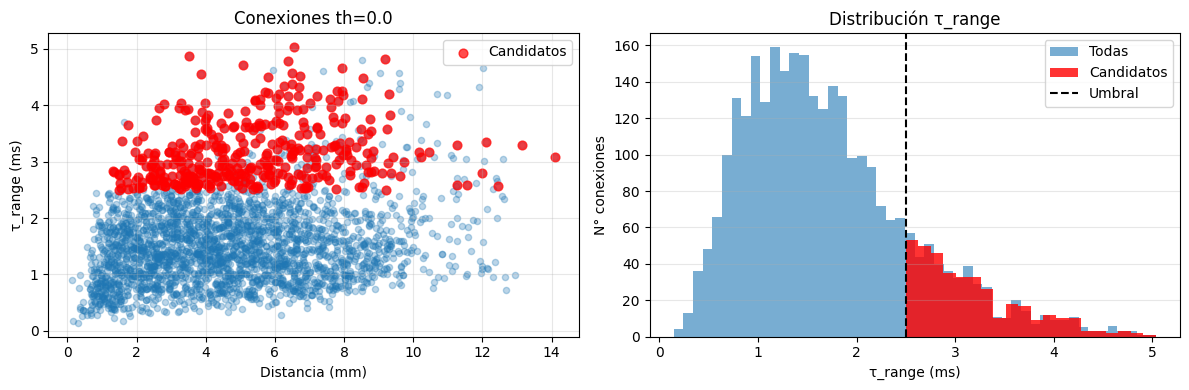

In [35]:
# Cargar resultados
df = pd.read_csv('../../results/data_analysis/results_th_0.0.csv')

print("="*70)
print("ANÁLISIS THRESHOLD 0.0")
print("="*70)
print(f"\nConexiones totales: {len(df)}")
print(f"Ratas por conexión: {df['n_rats'].min()}-{df['n_rats'].max()} (mediana: {df['n_rats'].median():.0f})")
print(f"Fibras por conexión: {df['n_fibers_mean'].describe()[['min', '50%', 'max']].to_dict()}")

# Métricas de largo alcance
print(f"\n{'LARGO ALCANCE':=^70}")
print(f"τ_range: {df['tau_range_mean'].min():.2f} - {df['tau_range_mean'].max():.2f} ms")
print(f"τ_range >3ms: {(df['tau_range_mean']>3).sum()} conexiones")
print(f"τ_range >2.5ms: {(df['tau_range_mean']>2.5).sum()} conexiones")
print(f"Distancia: {df['D_mean'].min():.1f} - {df['D_mean'].max():.1f} mm")

# Top 30 candidatos
print(f"\n{'TOP 30 CANDIDATOS':=^70}")
top30 = df.nlargest(30, 'tau_range_mean')
print(f"τ_range: {top30['tau_range_mean'].min():.2f} - {top30['tau_range_mean'].max():.2f} ms")
print(f"n_fibers: {top30['n_fibers_mean'].median():.0f} (mediana)")
print(f"18 ratas: {(top30['n_rats']==18).sum()} conexiones")

# Filtro estricto para selección final
candidates = df[
    (df['tau_range_mean'] > 2.5) &
    (df['n_fibers_mean'] > 100) &
    (df['n_rats'] >= 12)
].sort_values('tau_range_mean', ascending=False)

print(f"\n{'CANDIDATOS FINALES':=^70}")
print(f"Criterios: τ_range>2.5ms, n_fibers>100, ≥ 9 ratas")
print(f"Total: {len(candidates)} conexiones\n")
print(candidates[['roi_i', 'roi_j', 'roi_i_name', 'roi_j_name', 'n_rats', 'tau_range_mean', 
                  'D_mean', 'n_fibers_mean']].head(15).to_string(index=False))

# Guardar
candidates.to_csv('../../results/data_analysis/candidates_th_0.0_laxo.csv', index=False)
print(f"\n✓ Guardado: candidates_th_0.0.csv ({len(candidates)} conexiones)")

# Visualización rápida
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scatter: τ_range vs distancia
axes[0].scatter(df['D_mean'], df['tau_range_mean'], alpha=0.3, s=20)
axes[0].scatter(candidates['D_mean'], candidates['tau_range_mean'], 
               color='red', s=40, alpha=0.7, label='Candidatos')
axes[0].set_xlabel('Distancia (mm)')
axes[0].set_ylabel('τ_range (ms)')
axes[0].set_title('Conexiones th=0.0')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histograma τ_range
axes[1].hist(df['tau_range_mean'], bins=50, alpha=0.6, label='Todas')
axes[1].hist(candidates['tau_range_mean'], bins=20, alpha=0.8, 
            color='red', label='Candidatos')
axes[1].axvline(2.5, color='k', ls='--', lw=1.5, label='Umbral')
axes[1].set_xlabel('τ_range (ms)')
axes[1].set_ylabel('N° conexiones')
axes[1].set_title('Distribución τ_range')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
#plt.savefig('../../results/data_analysis/quick_analysis_th_0.0.png', dpi=150)
print("✓ Figura: quick_analysis_th_0.0_laxo.png")
plt.show()